In [1]:
import random
from models.model_v2 import *
from data.midi_preprocessing import *
from utils.dataset_loader import MaestroV3DataModule, MaestroV3DataSet
from pytorch_lightning.callbacks import ModelCheckpoint 
import pygame
import time

pygame 2.6.1 (SDL 2.28.4, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\kriptos\miniconda3\envs\jupyter_env\lib\site-packages\pretty_midi\instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
def ascolta_midi(file_midi: str):
    """
    Riproduce un file MIDI utilizzando pygame.

    Args:
        file_midi (str): path to the midi file to play.
    """
    try:
        # Initialize pygame mixer
        # These values are standard: frequency, bit, channels, buffer size
        pygame.mixer.init(44100, -16, 2, 512)

        pygame.init()

        print(f"🎵 Reproduction of'{file_midi}'...")

        # Load and play music
        pygame.mixer.music.load(file_midi)
        pygame.mixer.music.play()

        # Wait untile the song is fully played
        while pygame.mixer.music.get_busy():
            time.sleep(0.1)

    except pygame.error as e:
        print(f"Pygame error: {e}")
        print("Make sure the file loaded is valid")
    except FileNotFoundError:
        print(f"Error: File not found at the given path '{file_midi}'")
    finally:
        # Pulisci e chiudi pygame per liberare le risorse
        if pygame.get_init():
            pygame.mixer.music.stop()
            pygame.mixer.quit()
            pygame.quit()
        print("Reproduction ended.")

In [3]:
# Define the dataset.
data_file_path = "data/preprocessed/maestro-v3.0.0/dataset2/45k_augmented.h5"
dataset = MaestroV3DataSet(data_file_path, mode="pair")

# Random index.
rnd_idx = random.randint(0, len(dataset))

# Choose the first random sample from the dataset.
bar_0, _ = dataset[rnd_idx] # [1, 128, 16]
bar_0 = bar_0.unsqueeze(0)
print(bar_0.shape)

torch.Size([1, 1, 128, 16])


In [4]:

model = GAN.load_from_checkpoint("outputs/checkpoints/lightning_logs/version_1/checkpoints/fa_classifier_epoch=04.ckpt")

# Set model in evaluation.
model.eval()

# Generate noise.
noise = torch.randn(7, 1, 100)

#for z in noise:
#    print(z.shape)

# Generate 8 bar.
bars = [bar_0]
for i, z in enumerate(noise):
    # Previous bar.
    prev = bars[i-1]

    # Create the pair.
    x = z, prev

    # Generate current bar.
    curr = model(x)

    # Save genjerated bar
    bars.append(curr)

In [5]:
# Convert bars in numpy array.
bars_numpy = []
for bar in bars:
    bar = bar.squeeze(0, 1).detach().numpy()
    #print(bar.shape)
    bars_numpy.append(bar)

Bar 0


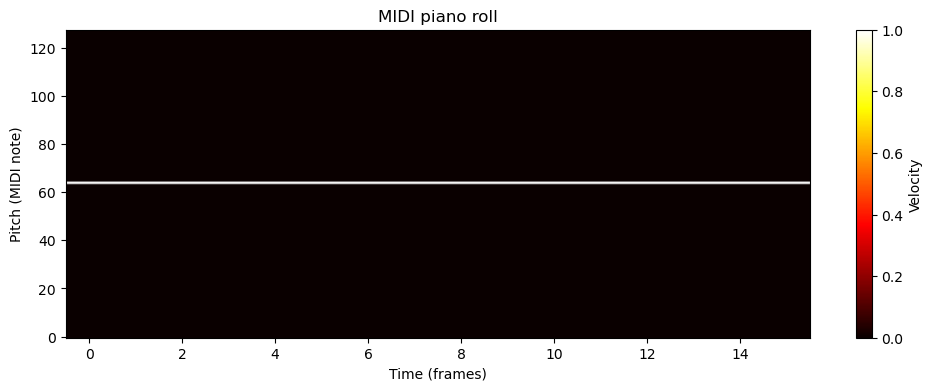

Bar 1


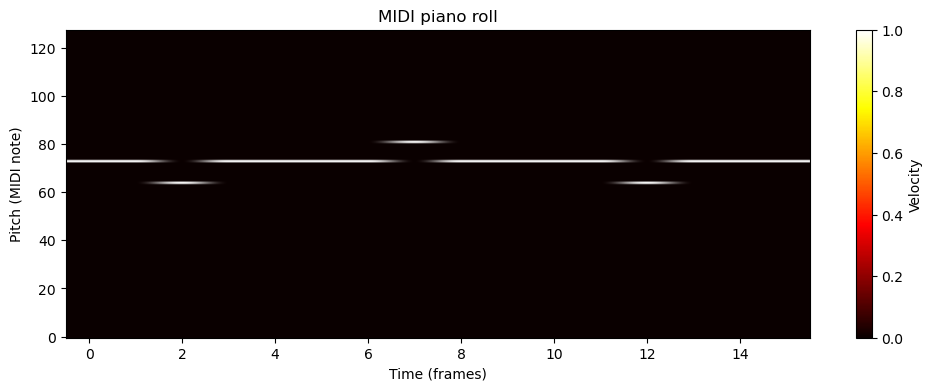

Bar 2


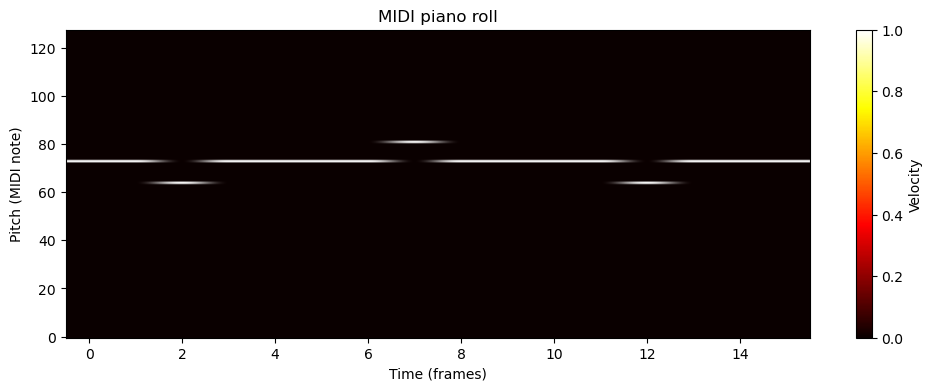

Bar 3


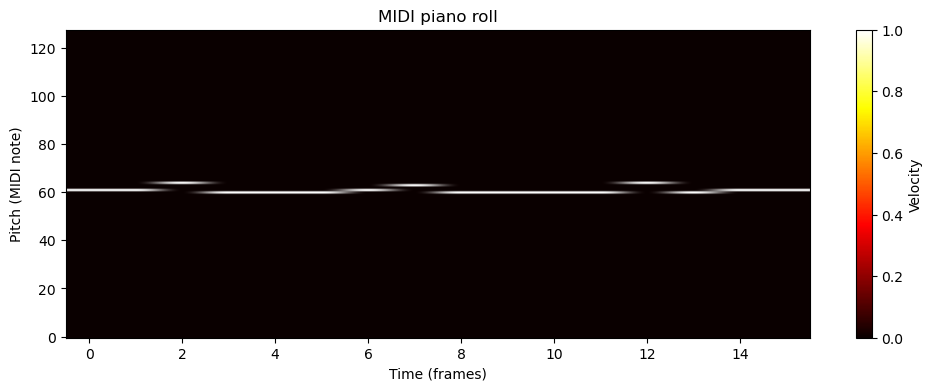

Bar 4


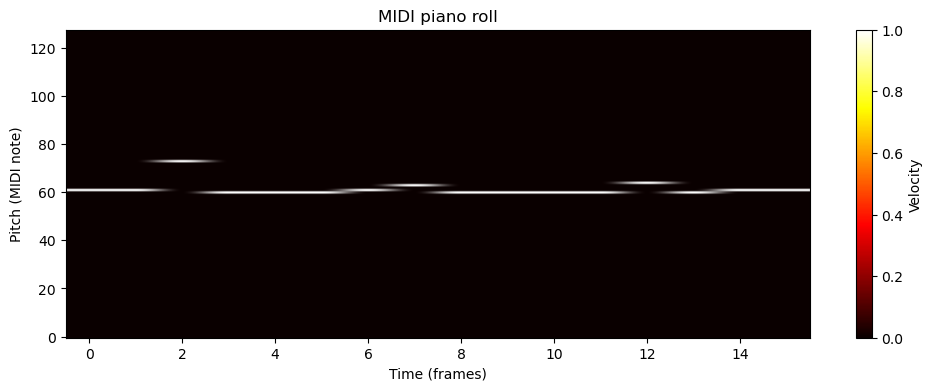

Bar 5


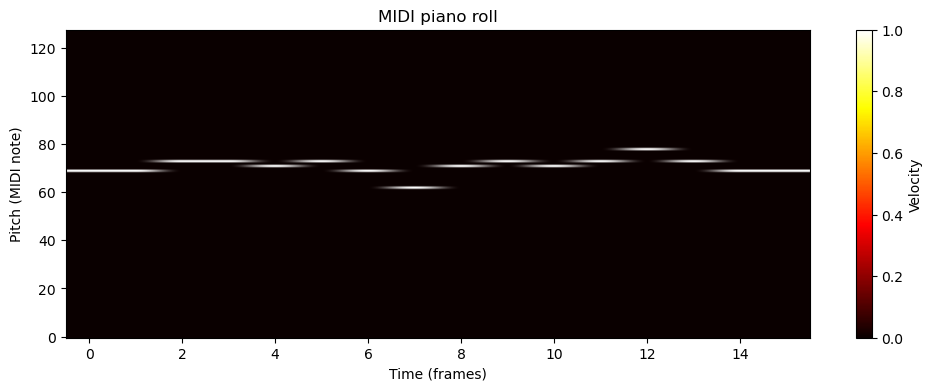

Bar 6


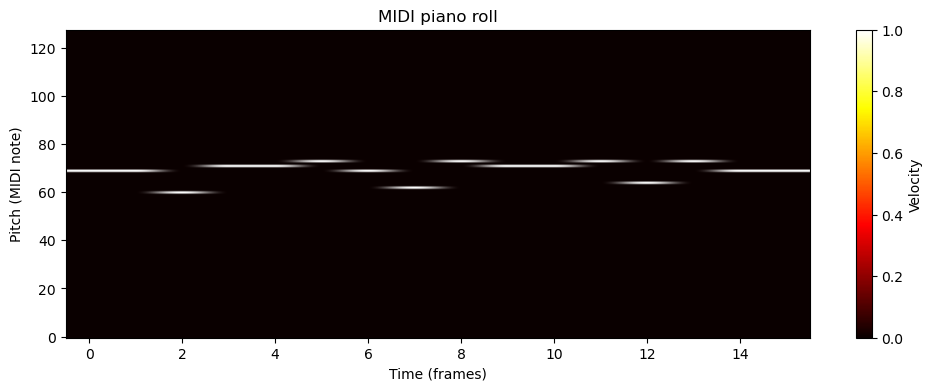

Bar 7


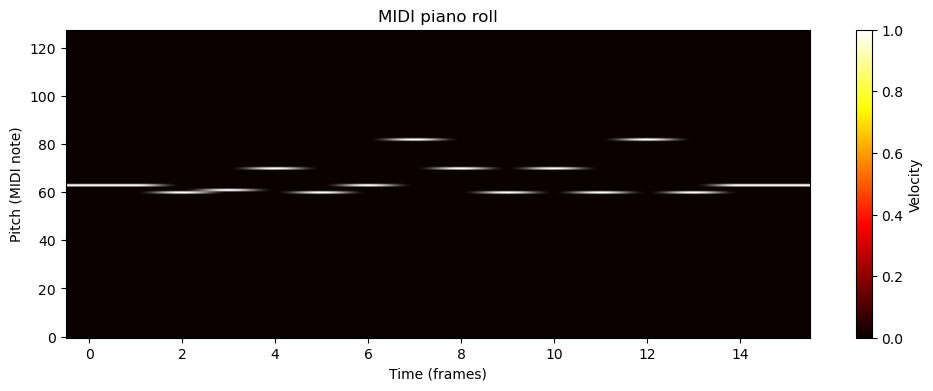

In [6]:
# Plot each single bar.
for i, bar in enumerate(bars_numpy):
    print("Bar", i)
    show_piano_roll(bar)

Full piano roll
Shape: (128, 128)


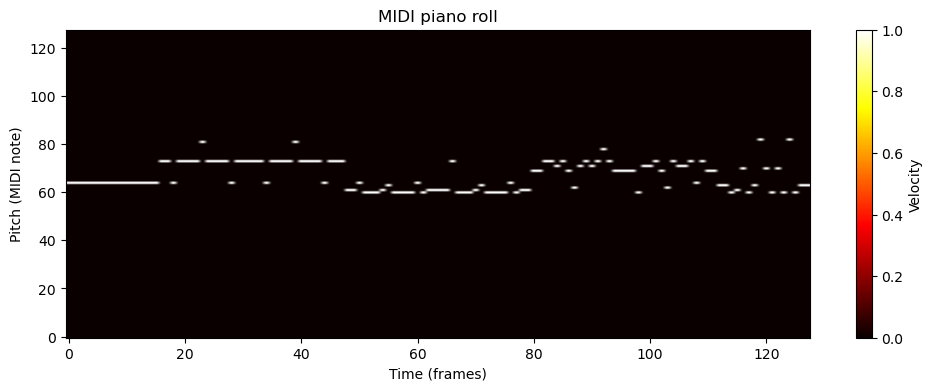

In [7]:
# Create the full piano roll.
full_piano_roll = np.hstack([bar for bar in bars_numpy])
print("Full piano roll")
print("Shape:", full_piano_roll.shape)
show_piano_roll(full_piano_roll)

# Multiply by 50.
full_piano_roll *= 50

In [8]:
# Create the output midi file.
pm = piano_roll_to_pretty_midi(full_piano_roll, fs=8)
output_fn = "output_test.midi"
pm.write(output_fn)

In [9]:
ascolta_midi("output_test.midi")

🎵 Reproduction of'output_test.midi'...
Reproduction ended.
